In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy import ndimage
import pandas as pd

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, f1_score, accuracy_score, recall_score

from tensorflow.keras import models, layers, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

from PIL import Image


from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, \
Activation, Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import LeakyReLU

import os

In [2]:
base_dir='../data/chest_xray/'

train_path = '../data/chest_xray/train'

validation_path = '../data/chest_xray/val'

test_path = '../data/chest_xray/test'

full_train_path = '../data/chest_xray/full_train'

##paths to different folders and types of data

In [3]:
train_pneumonia=os.listdir('../data/chest_xray/train/PNEUMONIA/')
train_normal=os.listdir('../data/chest_xray/train/NORMAL/')
val_dir_normal=os.listdir('../data/chest_xray/val/NORMAL/')
test_dir_normal=os.listdir('../data/chest_xray/test/NORMAL/')
val_dir_pneumonia=os.listdir('../data/chest_xray/val/PNEUMONIA/')
test_dir_pneumonia=os.listdir('../data/chest_xray/test/PNEUMONIA/')


##trying out combining training and validation sets and using a validation ratio when fitting models
full_train_pneumonia = os.listdir('../data/chest_xray/full_train/PNEUMONIA')
full_train_normal = os.listdir('../data/chest_xray/full_train/NORMAL')


##list object containing 'NORMAL' & 'PNEUMONIA'
label_string = os.listdir('../data/chest_xray/train')

In [4]:
# Greyscale distribution histogram - done, Jamie
# Class distribution - heavily weighted towards positive class (pneumonia) - done, Jamie
# Address class imbalance - incorporate flipped 0-class images - Rachel wrote a function for this
# Mean values for negative and positive classes - Svitlana 
# Look for outliers
# Look at subracting the pixel mean
# Apply matrix transformations to further define images - 
# Data Augmentation - Svitlana will make an attempt

In [5]:
print("Train set w/ pneumonia: ", len(train_pneumonia))
print("Train set normal: ", len(train_normal))
print("Validation set w/ pneumonia: ", len(val_dir_pneumonia))
print("Validation set normal: ", len(val_dir_normal))
print("Test set w/ pneumonia: ", len(test_dir_pneumonia))
print("Test set normal: ", len(test_dir_normal))
print("Full training set w/pneumonia (combined w/validation): ", len(full_train_pneumonia))
print("Full training set normal (combined w/validation): ", len(full_train_normal))

Train set w/ pneumonia:  2144
Train set normal:  699
Validation set w/ pneumonia:  1739
Validation set normal:  650
Test set w/ pneumonia:  390
Test set normal:  234
Full training set w/pneumonia (combined w/validation):  3883
Full training set normal (combined w/validation):  1349


In [6]:
2144+699, 1739+650, 390+234, 3883+1349 ##total values for batch sizes

(2843, 2389, 624, 5232)

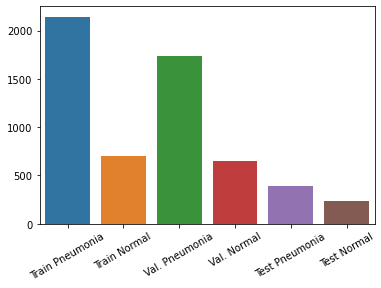

In [7]:
labels = ['Train Pneumonia', 'Train Normal', 'Val. Pneumonia', 'Val. Normal', 'Test Pneumonia', 'Test Normal']
dist = sns.barplot(x=labels, 
           y=[len(train_pneumonia), len(train_normal), len(val_dir_pneumonia), len(val_dir_normal), len(test_dir_pneumonia), len(test_dir_normal)],)

dist.set_xticklabels(labels = labels, rotation = 30);

There is a class imbalance between the positive class (pneumonia) and negative class (normal), which could potentially pose a challenge when training the model. We will be experimenting with data augmentation should the need arise.

In [8]:
#loading images for training set - pneumonia

plt.suptitle("Patients with Pneumonia")
for i in range(0,4):
    img = train_pneumonia[i]
    img = load_img(train_path+'/PNEUMONIA/'+img)
#   plt.imshow(img)
#   plt.show()

<Figure size 432x288 with 0 Axes>

In [9]:
#loading images for training set - normal

plt.suptitle("Normal Patients")
for i in range(0,4):
    img = train_normal[i]
    img = load_img(train_path+'/NORMAL/'+img)
#    plt.imshow(img)
#    plt.show()

<Figure size 432x288 with 0 Axes>

In [10]:
train_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=2843,
                                                 color_mode = 'grayscale',                
                                                 class_mode='binary')

val_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(validation_path,
                                            target_size=(224, 224),
                                            shuffle=True,
                                            batch_size=2389,
                                            color_mode = 'grayscale',                      
                                            class_mode='binary')

test_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=624,
                                            color_mode = 'grayscale',                        
                                            class_mode='binary')

##Image generator object for full training folder
full_train_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(full_train_path,
                                            target_size=(224, 224),
                                            batch_size=5232,
                                            color_mode = 'grayscale',                        
                                            class_mode='binary')

Found 2843 images belonging to 2 classes.
Found 2389 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [11]:
train_images, train_labels = next(train_gen)
val_images, val_labels = next(val_gen)
test_images, test_labels = next(test_gen)

##full training folder
full_train_images, full_train_labels = next(full_train_gen)

In [13]:
print("Train image shape:", train_images.shape, "train label shape:", train_labels.shape)
print("Val image shape:", val_images.shape, "val label shape:", val_labels.shape)
print("Test image shape:", test_images.shape, "test label shape:", test_labels.shape)

print("Full Train image shape:", full_train_images.shape, "full train label shape:", full_train_labels.shape)

Train image shape: (2843, 224, 224, 1) train label shape: (2843,)
Val image shape: (2389, 224, 224, 1) val label shape: (2389,)
Test image shape: (624, 224, 224, 1) test label shape: (624,)
Full Train image shape: (5232, 224, 224, 1) full train label shape: (5232,)


In [14]:
train_x = train_images.reshape(train_images.shape[0], -1)
val_x = val_images.reshape(val_images.shape[0], -1)
test_x = test_images.reshape(test_images.shape[0], -1)

full_train_x = full_train_images.reshape(full_train_images.shape[0], -1)

In [15]:
train_x.shape, val_x.shape, test_x.shape, full_train_x.shape

((2843, 50176), (2389, 50176), (624, 50176), (5232, 50176))

In [16]:
train_y = np.reshape(train_labels[:], (2843,1))
val_y = np.reshape(val_labels[:], (2389,1))
test_y = np.reshape(test_labels[:], (624,1))

##full training set labels
full_train_y = np.reshape(full_train_labels[:], (5232,1))

In [17]:
train_y.shape, val_y.shape, test_y.shape, full_train_y.shape

((2843, 1), (2389, 1), (624, 1), (5232, 1))

Note: This modeling was initially performed on a training and validation set as obtained through Kaggle. The final notebook code does change to reflect a different split of training and validation data.

# FSM  
For a first simple model, I selected building a densely-connected network with one hidden layer to create a baseline expectation of performance. 

In [18]:
np.random.seed(42)


fsm = models.Sequential()
fsm.add(layers.Dense(12, activation='relu', input_shape=(50176,)))
fsm.add(layers.Dense(7, activation='relu'))
fsm.add(layers.Dense(1, activation='sigmoid'))

The first simple model will be using stochastic gradient descent and measuring both accuracy and recall - the model's overall performance and its ability to correctly predict the positive class.

In [19]:
np.random.seed(42) ##setting a random state for reproduceability

fsm.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics= (['accuracy'], metrics.Recall()))

%timeit
history = fsm.fit(train_x,
                    train_y,
                    epochs=25,
                    batch_size=32,
                    validation_data=(val_x, val_y))

Epoch 1/25
89/89 [==============================] - 1s 12ms/step - loss: 0.5004 - accuracy: 0.7598 - recall: 0.9650 - val_loss: 0.5124 - val_accuracy: 0.8238 - val_recall: 0.8033
Epoch 2/25
89/89 [==============================] - 1s 8ms/step - loss: 0.4237 - accuracy: 0.8002 - recall: 0.9515 - val_loss: 0.4119 - val_accuracy: 0.8296 - val_recall: 0.9919
Epoch 3/25
89/89 [==============================] - 1s 8ms/step - loss: 0.3270 - accuracy: 0.8646 - recall: 0.9408 - val_loss: 0.2854 - val_accuracy: 0.8870 - val_recall: 0.8919
Epoch 4/25
89/89 [==============================] - 1s 9ms/step - loss: 0.2564 - accuracy: 0.9036 - recall: 0.9529 - val_loss: 0.2188 - val_accuracy: 0.9096 - val_recall: 0.9505
Epoch 5/25
89/89 [==============================] - 1s 11ms/step - loss: 0.2581 - accuracy: 0.8959 - recall: 0.9487 - val_loss: 0.3932 - val_accuracy: 0.8242 - val_recall: 0.7654
Epoch 6/25
89/89 [==============================] - 1s 11ms/step - loss: 0.2281 - accuracy: 0.9110 - recall:

In [20]:
fsm_preds = np.round(fsm.predict(train_x)).astype(int)

In [21]:
fsm_true = train_y

In [22]:
print(f'Confusion matrix:\n {confusion_matrix(train_y, fsm_preds)}\n')
print(f'F1 score: {f1_score(train_y, fsm_preds)}')
print(f'Recall: {recall_score(train_y, fsm_preds)}')
print(f'Accuracy: {accuracy_score(train_y, fsm_preds)}')

Confusion matrix:
 [[ 682   17]
 [ 139 2005]]

F1 score: 0.9625540086413826
Recall: 0.9351679104477612
Accuracy: 0.945128385508266


Based off this first simple model, it performs fairly decently on the training set but does have a large false negative count.

In [23]:
np.random.seed(42)

dense = models.Sequential()
dense.add(layers.Dense(12, activation='relu', input_shape=(50176,)))
dense.add(layers.Dense(7, activation='relu'))
dense.add(layers.Dense(1, activation='sigmoid'))


dense.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics= (['accuracy'], metrics.Recall()))


history = dense.fit(train_x,
                    train_y,
                    epochs=25,
                    batch_size=32,
                    validation_data=(val_x, val_y))

Epoch 1/25
89/89 [==============================] - 1s 13ms/step - loss: 1.5796 - accuracy: 0.7397 - recall_1: 0.9701 - val_loss: 0.5786 - val_accuracy: 0.7279 - val_recall_1: 1.0000
Epoch 2/25
89/89 [==============================] - 1s 11ms/step - loss: 0.8644 - accuracy: 0.7309 - recall_1: 0.9641 - val_loss: 0.5568 - val_accuracy: 0.7279 - val_recall_1: 1.0000
Epoch 3/25
89/89 [==============================] - 1s 11ms/step - loss: 0.4387 - accuracy: 0.7974 - recall_1: 0.9888 - val_loss: 0.4901 - val_accuracy: 0.7899 - val_recall_1: 0.7441
Epoch 4/25
89/89 [==============================] - 1s 11ms/step - loss: 0.3487 - accuracy: 0.8670 - recall_1: 0.9361 - val_loss: 0.4307 - val_accuracy: 0.8079 - val_recall_1: 0.9971
Epoch 5/25
89/89 [==============================] - 1s 13ms/step - loss: 0.3127 - accuracy: 0.8874 - recall_1: 0.9454 - val_loss: 0.3036 - val_accuracy: 0.9062 - val_recall_1: 0.9235
Epoch 6/25
89/89 [==============================] - 1s 14ms/step - loss: 0.2850 - acc

In [24]:
dense_preds = np.round(dense.predict(train_x)).astype(int)
dense_true = train_y
print(f'Confusion matrix:\n {confusion_matrix(dense_true, dense_preds)}\n')
print(f'F1 score: {f1_score(dense_true, dense_preds)}')
print(f'Recall: {recall_score(dense_true, dense_preds)}')
print(f'Accuracy: {accuracy_score(dense_true, dense_preds)}')

Confusion matrix:
 [[ 675   24]
 [  81 2063]]

F1 score: 0.9751831718269912
Recall: 0.9622201492537313
Accuracy: 0.9630671825536405


RMS prop actually reduced the number of false negatives.

# First CNN 

We implemented an early stopping callback in order to minimize time spent running each model - the metrics were set to measure minimal loss on the validation set with a 3-epoch tolerance.

In [25]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224 , 224, 1)))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3)
##instantiating early stopping with a 3-epoch tolerance for minimizing loss

In [27]:
cnn.compile(optimizer = 'rmsprop', 
              loss = 'binary_crossentropy', 
              metrics = (['accuracy'], metrics.Recall()))

In [28]:
cnn_hist = cnn.fit(train_images, train_labels, 
                     epochs = 25, 
                     batch_size = 64, 
                     validation_data=(val_images, val_y), 
                     callbacks = [es])

Epoch 1/25
45/45 [==============================] - 111s 2s/step - loss: 0.5033 - accuracy: 0.8002 - recall_3: 0.8619 - val_loss: 0.2494 - val_accuracy: 0.9021 - val_recall_3: 0.9569
Epoch 2/25
45/45 [==============================] - 103s 2s/step - loss: 0.2063 - accuracy: 0.9237 - recall_3: 0.9520 - val_loss: 0.2383 - val_accuracy: 0.9062 - val_recall_3: 0.8821
Epoch 3/25
45/45 [==============================] - 104s 2s/step - loss: 0.1459 - accuracy: 0.9497 - recall_3: 0.9627 - val_loss: 0.2971 - val_accuracy: 0.9008 - val_recall_3: 0.9960
Epoch 4/25
45/45 [==============================] - 106s 2s/step - loss: 0.1162 - accuracy: 0.9624 - recall_3: 0.9739 - val_loss: 0.1745 - val_accuracy: 0.9376 - val_recall_3: 0.9626
Epoch 5/25
45/45 [==============================] - 107s 2s/step - loss: 0.1060 - accuracy: 0.9666 - recall_3: 0.9790 - val_loss: 0.2230 - val_accuracy: 0.9309 - val_recall_3: 0.9827
Epoch 6/25
45/45 [==============================] - 113s 3s/step - loss: 0.0613 - acc

In [31]:
cnn_results = cnn.evaluate(train_images, train_y)

89/89 [==============================] - 24s 270ms/step - loss: 0.0908 - accuracy: 0.9613 - recall_3: 0.9995


In [32]:
cnn.evaluate(val_images, val_y)

75/75 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.9025 - recall_3: 0.996 - 18s 235ms/step - loss: 0.3785 - accuracy: 0.9025 - recall_3: 0.9965


[0.3785286843776703, 0.9024696350097656, 0.9965497255325317]

In [33]:
cnn_hist.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x193b5a0e1c0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.5032622218132019,
   0.20626778900623322,
   0.1459026038646698,
   0.11623724550008774,
   0.10604668408632278,
   0.061259377747774124,
   0.05131847411394119,
   0.05208601802587509,
   0.03265794739127159],
  'accuracy': [0.8002110719680786,
   0.9236721992492676,
   0.9497010111808777,
   0.9623637199401855,
   0.9665846228599548,
   0.9810059666633606,
   0.9810059666633606,
   0.9824129343032837,
   0.9894477725028992],
  'recall_3': [0.861940324306488,
   0.951958954334259,
   0.9626865386962891,
   0.9738805890083313,
   0.9790111780166626,
   0.985541045665741,
   0.9878731369972229,
   0.9883395433425903,
   0.9925373196601868],
  'val_loss': [0.24943530559539795,
   0.23833055794239044,
   0.2971174418926239,
   0.17449668049812317,
   0.22300784289836884,
   0.15185709297657013,
   0.1

In [35]:
model_epochs = cnn_hist.epoch
model_recall_train = cnn_hist.history['recall_3']
model_recall_val = cnn_hist.history['val_recall_3']
model_accuracy_train = cnn_hist.history['accuracy']
model_accuracy_val = cnn_hist.history['val_accuracy']
model_loss_train = cnn_hist.history['loss']
model_loss_val = cnn_hist.history['val_loss']

## Plotting Metrics of First CNN

### Accuracy, Recall, Loss

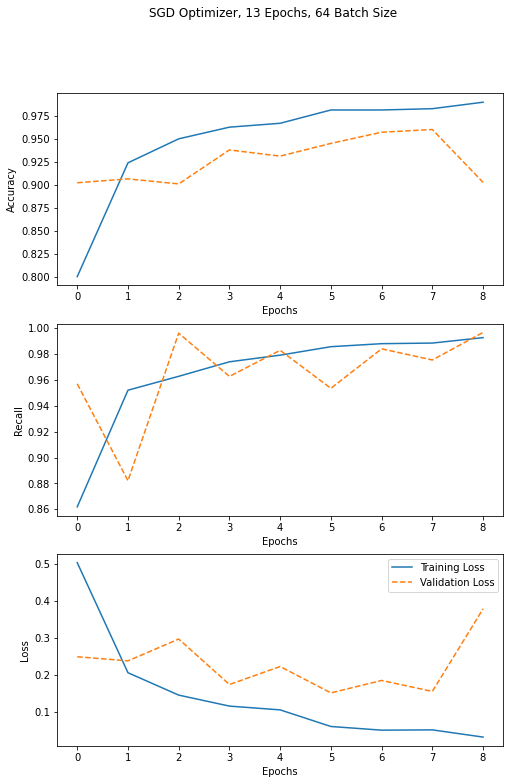

In [36]:
fig, axs = plt.subplots(3, figsize = (8,12))

plt.suptitle("SGD Optimizer, 13 Epochs, 64 Batch Size")

axs[0].plot(model_epochs, model_accuracy_train, label = 'Training Accuracy')
axs[0].plot(model_epochs, model_accuracy_val, linestyle = '--', label = 'Validation Accuracy')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")



axs[1].plot(model_epochs, model_recall_train, label = 'Training Recall')
axs[1].plot(model_epochs, model_recall_val, linestyle = '--', label = 'Validation Recall')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Recall")



axs[2].plot(model_epochs, model_loss_train, label = 'Training Loss')
axs[2].plot(model_epochs, model_loss_val, linestyle = '--', label = 'Validation Loss')
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Loss")
plt.legend();

## CNN2

In [37]:
cnn2 = models.Sequential()
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224 , 224, 1)))
cnn2.add(layers.MaxPooling2D((2, 2)))

cnn2.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 2)))

cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(64, activation='relu'))
cnn2.add(layers.Dense(1, activation='sigmoid'))


cnn2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [38]:
hist2 = cnn2.fit(train_images, train_labels, 
                 epochs = 25, 
                 batch_size = 64, 
                 validation_data=(val_images, val_y), 
                 callbacks = [es])

Epoch 1/25
45/45 [==============================] - 99s 2s/step - loss: 0.8835 - accuracy: 0.7626 - recall_4: 0.8839 - val_loss: 0.3845 - val_accuracy: 0.8221 - val_recall_4: 0.9551
Epoch 2/25
45/45 [==============================] - 101s 2s/step - loss: 0.2558 - accuracy: 0.9040 - recall_4: 0.9347 - val_loss: 0.3349 - val_accuracy: 0.8535 - val_recall_4: 0.9626
Epoch 3/25
45/45 [==============================] - 101s 2s/step - loss: 0.1711 - accuracy: 0.9381 - recall_4: 0.9585 - val_loss: 0.3321 - val_accuracy: 0.8736 - val_recall_4: 0.9919
Epoch 4/25
45/45 [==============================] - 102s 2s/step - loss: 0.1259 - accuracy: 0.9529 - recall_4: 0.9664 - val_loss: 4.9180 - val_accuracy: 0.7279 - val_recall_4: 1.0000
Epoch 5/25
45/45 [==============================] - 100s 2s/step - loss: 0.3172 - accuracy: 0.9539 - recall_4: 0.9734 - val_loss: 0.1931 - val_accuracy: 0.9259 - val_recall_4: 0.9178
Epoch 6/25
45/45 [==============================] - 99s 2s/step - loss: 0.0733 - accur

In [39]:
cnn2_train_results = cnn2.evaluate(train_images, train_labels)

89/89 [==============================] - 16s 177ms/step - loss: 0.0159 - accuracy: 0.9947 - recall_4: 0.9958


In [40]:
cnn2_val_results = cnn2.evaluate(val_images, val_labels)

75/75 [==============================] - 13s 174ms/step - loss: 0.2035 - accuracy: 0.9531 - recall_4: 0.9839


In [41]:
hist2.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x193b81e7be0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.8835479021072388,
   0.25578925013542175,
   0.1710827648639679,
   0.12594342231750488,
   0.3172363042831421,
   0.07325722277164459,
   0.09995625168085098,
   0.037934496998786926],
  'accuracy': [0.7625747323036194,
   0.9039746522903442,
   0.9380935430526733,
   0.9528666734695435,
   0.953921914100647,
   0.9771368503570557,
   0.9704537391662598,
   0.9876890778541565],
  'recall_4': [0.8838619589805603,
   0.9347015023231506,
   0.9584888219833374,
   0.9664179086685181,
   0.9734141826629639,
   0.9822761416435242,
   0.9780783653259277,
   0.9897388219833374],
  'val_loss': [0.38450947403907776,
   0.33490845561027527,
   0.3321119546890259,
   4.917964458465576,
   0.19306793808937073,
   0.5190214514732361,
   0.22920599579811096,
   0.20348328351974487],
  'val_accuracy': [0.82210129

In [42]:
cnn2_epochs = hist2.epoch
cnn2_recall_train = hist2.history['recall_4']
cnn2_recall_val = hist2.history['val_recall_4']
cnn2_accuracy_train = hist2.history['accuracy']
cnn2_accuracy_val = hist2.history['val_accuracy']
cnn2_loss_train = hist2.history['loss']
cnn2_loss_val = hist2.history['val_loss']

## Plotting Metrics of 2nd CNN

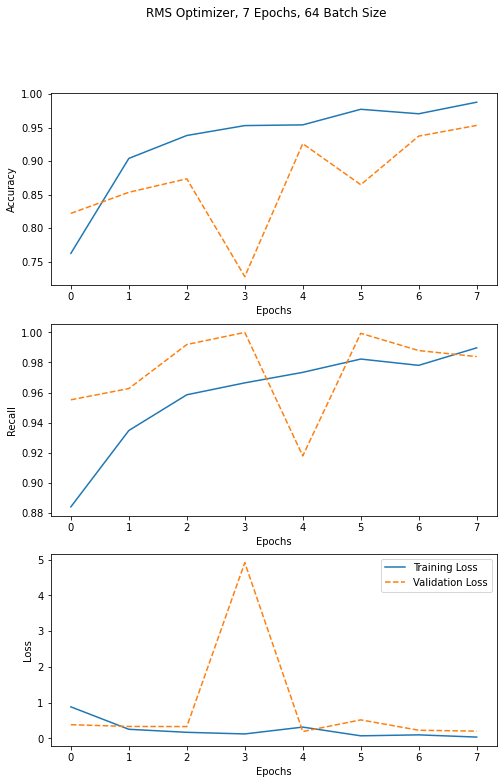

In [43]:
fig, axs = plt.subplots(3, figsize = (8,12))

plt.suptitle("RMS Optimizer, 7 Epochs, 64 Batch Size")

axs[0].plot(cnn2_epochs, cnn2_accuracy_train, label = 'Training Accuracy')
axs[0].plot(cnn2_epochs, cnn2_accuracy_val, linestyle = '--', label = 'Validation Accuracy')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")



axs[1].plot(cnn2_epochs, cnn2_recall_train, label = 'Training Recall')
axs[1].plot(cnn2_epochs, cnn2_recall_val, linestyle = '--', label = 'Validation Recall')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Recall")



axs[2].plot(cnn2_epochs, cnn2_loss_train, label = 'Training Loss')
axs[2].plot(cnn2_epochs, cnn2_loss_val, linestyle = '--', label = 'Validation Loss')
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Loss")
plt.legend();

RMSProp (or root mean squared propagation) was more successful with similar metrics as the initial model, so we will proceed with using rmsprop as the optimizer.

## CNN3

We have included 'tanh' (or hyperbolic tangent) activation into this model in order to account for potential negative values.

In [44]:
cnn3 = models.Sequential()
cnn3.add(layers.Conv2D(32, (3, 3), activation='tanh',
                        input_shape=(224 , 224, 1)))
cnn3.add(layers.MaxPooling2D((2, 2)))

cnn3.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn3.add(layers.MaxPooling2D((2, 2)))

cnn3.add(layers.Flatten())
cnn3.add(layers.Dropout(.3))

cnn3.add(layers.Dense(64, activation='relu'))
cnn3.add(layers.Dense(1, activation='sigmoid'))


cnn3.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [45]:
np.random.seed(111)
hist3 = cnn3.fit(train_images, train_labels, 
                      epochs = 25, 
                      batch_size = 64, 
                      validation_data=(val_images, val_labels), 
                      callbacks = [es])

Epoch 1/25
45/45 [==============================] - 91s 2s/step - loss: 0.8925 - accuracy: 0.7485 - recall_5: 0.9478 - val_loss: 0.4889 - val_accuracy: 0.7781 - val_recall_5: 0.9459
Epoch 2/25
45/45 [==============================] - 96s 2s/step - loss: 0.4175 - accuracy: 0.8333 - recall_5: 0.8820 - val_loss: 0.3132 - val_accuracy: 0.8644 - val_recall_5: 0.8631
Epoch 3/25
45/45 [==============================] - 99s 2s/step - loss: 0.2453 - accuracy: 0.9040 - recall_5: 0.9310 - val_loss: 0.4169 - val_accuracy: 0.8652 - val_recall_5: 0.9931
Epoch 4/25
45/45 [==============================] - 93s 2s/step - loss: 0.2449 - accuracy: 0.9349 - recall_5: 0.9552 - val_loss: 0.1948 - val_accuracy: 0.9154 - val_recall_5: 0.8994
Epoch 5/25
45/45 [==============================] - 94s 2s/step - loss: 0.1519 - accuracy: 0.9483 - recall_5: 0.9660 - val_loss: 0.1706 - val_accuracy: 0.9443 - val_recall_5: 0.9868
Epoch 6/25
45/45 [==============================] - 95s 2s/step - loss: 0.1319 - accuracy:

In [47]:
cnn3_train_results = cnn3.evaluate(train_images, train_labels)

89/89 [==============================] - 16s 175ms/step - loss: 0.0228 - accuracy: 0.9940 - recall_5: 0.9977


In [48]:
cnn3_val_results = cnn3.evaluate(val_images, val_labels)

75/75 [==============================] - 16s 211ms/step - loss: 0.1712 - accuracy: 0.9527 - recall_5: 0.9896


In [49]:
hist3.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x193b8794880>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.892480731010437,
   0.4174676835536957,
   0.2452724426984787,
   0.24487176537513733,
   0.15190814435482025,
   0.1319299340248108,
   0.12603819370269775,
   0.0445171482861042,
   0.05184879153966904,
   0.3937292993068695],
  'accuracy': [0.7485051155090332,
   0.8332747220993042,
   0.9039746522903442,
   0.9349278807640076,
   0.9482940435409546,
   0.9634189009666443,
   0.9616602063179016,
   0.9859303832054138,
   0.9834681749343872,
   0.9778403043746948],
  'recall_5': [0.9477611780166626,
   0.8819962739944458,
   0.9309701323509216,
   0.9552238583564758,
   0.9659515023231506,
   0.9729477763175964,
   0.9720149040222168,
   0.9888059496879578,
   0.98927241563797,
   0.9860074520111084],
  'val_loss': [0.4888593554496765,
   0.31323403120040894,
   0.4169129431247711,
   0.194833502

In [50]:
cnn3_epochs = hist3.epoch
cnn3_recall_train = hist3.history['recall_5']
cnn3_recall_val = hist3.history['val_recall_5']
cnn3_accuracy_train = hist3.history['accuracy']
cnn3_accuracy_val = hist3.history['val_accuracy']
cnn3_loss_train = hist3.history['loss']
cnn3_loss_val = hist3.history['val_loss']

## Plotting CNN3

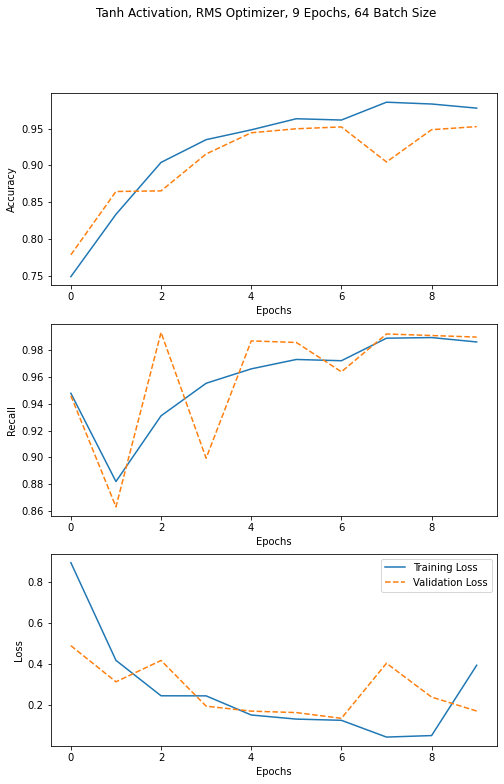

In [51]:
fig, axs = plt.subplots(3, figsize = (8,12))

plt.suptitle("Tanh Activation, RMS Optimizer, 9 Epochs, 64 Batch Size")

axs[0].plot(cnn3_epochs, cnn3_accuracy_train, label = 'Training Accuracy')
axs[0].plot(cnn3_epochs, cnn3_accuracy_val, linestyle = '--', label = 'Validation Accuracy')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")



axs[1].plot(cnn3_epochs, cnn3_recall_train, label = 'Training Recall')
axs[1].plot(cnn3_epochs, cnn3_recall_val, linestyle = '--', label = 'Validation Recall')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Recall")



axs[2].plot(cnn3_epochs, cnn3_loss_train, label = 'Training Loss')
axs[2].plot(cnn3_epochs, cnn3_loss_val, linestyle = '--', label = 'Validation Loss')
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Loss")
plt.legend();

## CNN 4 - further fiddling
Introducing a Leaky ReLu activation layer and a densely connected layer with 128 neurons.

In [52]:
cnn4 = models.Sequential()
cnn4.add(layers.Conv2D(32, (3, 3), activation='tanh',
                        input_shape=(224 , 224, 1)))
cnn4.add(layers.MaxPooling2D((2, 2)))

cnn4.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn4.add(layers.MaxPooling2D((2, 2)))


cnn4.add(LeakyReLU())
cnn4.add(layers.MaxPooling2D((2, 2), padding = 'same'))

cnn4.add(layers.Dropout(.3))
cnn4.add(layers.Flatten())

cnn4.add(layers.Dense(128, activation='relu'))
cnn4.add(layers.Dense(64, activation='relu'))
cnn4.add(layers.Dense(1, activation='sigmoid'))


cnn4.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [53]:
hist4 = cnn4.fit(train_images, train_labels, 
                 epochs = 25, batch_size = 64, 
                 validation_data=(val_images, val_labels), 
                 callbacks = [es])

Epoch 1/25
45/45 [==============================] - 92s 2s/step - loss: 0.8166 - accuracy: 0.7460 - recall_6: 0.9534 - val_loss: 0.5748 - val_accuracy: 0.7120 - val_recall_6: 0.6090
Epoch 2/25
45/45 [==============================] - 96s 2s/step - loss: 0.3139 - accuracy: 0.8857 - recall_6: 0.9352 - val_loss: 0.4532 - val_accuracy: 0.8179 - val_recall_6: 0.9965
Epoch 3/25
45/45 [==============================] - 93s 2s/step - loss: 0.2123 - accuracy: 0.9159 - recall_6: 0.9459 - val_loss: 0.4405 - val_accuracy: 0.8271 - val_recall_6: 0.9983
Epoch 4/25
45/45 [==============================] - 91s 2s/step - loss: 0.1756 - accuracy: 0.9423 - recall_6: 0.9683 - val_loss: 0.1958 - val_accuracy: 0.9150 - val_recall_6: 0.8942
Epoch 5/25
45/45 [==============================] - 91s 2s/step - loss: 0.1602 - accuracy: 0.9437 - recall_6: 0.9650 - val_loss: 0.2066 - val_accuracy: 0.9247 - val_recall_6: 0.9891
Epoch 6/25
45/45 [==============================] - 91s 2s/step - loss: 0.1418 - accuracy:

In [54]:
cnn4_train_results = cnn4.evaluate(train_images, train_labels)

89/89 [==============================] - 15s 171ms/step - loss: 0.0784 - accuracy: 0.9712 - recall_6: 0.9622


In [55]:
cnn4_val_results = cnn4.evaluate(val_images, val_labels)

75/75 [==============================] - 15s 200ms/step - loss: 0.1338 - accuracy: 0.9598 - recall_6: 0.9534


In [56]:
hist4.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x193b94f8f10>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.816592276096344,
   0.3138521909713745,
   0.21227316558361053,
   0.1756095439195633,
   0.1602081060409546,
   0.1417633295059204,
   0.0883697047829628,
   0.08989141881465912,
   0.07377240806818008,
   0.06073673069477081],
  'accuracy': [0.7460429072380066,
   0.8856841325759888,
   0.9159338474273682,
   0.9423144459724426,
   0.9437214136123657,
   0.9507562518119812,
   0.9662328362464905,
   0.9715089797973633,
   0.9725642204284668,
   0.9771368503570557],
  'recall_6': [0.9533582329750061,
   0.9351679086685181,
   0.9458954930305481,
   0.9682835936546326,
   0.965018630027771,
   0.9696828126907349,
   0.9766790866851807,
   0.9808768630027771,
   0.9808768630027771,
   0.9827425479888916],
  'val_loss': [0.5748327374458313,
   0.45322126150131226,
   0.44049590826034546,
   0.1957861

In [57]:
cnn4_epochs = hist4.epoch
cnn4_recall_train = hist4.history['recall_6']
cnn4_recall_val = hist4.history['val_recall_6']
cnn4_accuracy_train = hist4.history['accuracy']
cnn4_accuracy_val = hist4.history['val_accuracy']
cnn4_loss_train = hist4.history['loss']
cnn4_loss_val = hist4.history['val_loss']

## CNN4 - Plotting Metrics

No handles with labels found to put in legend.
No handles with labels found to put in legend.


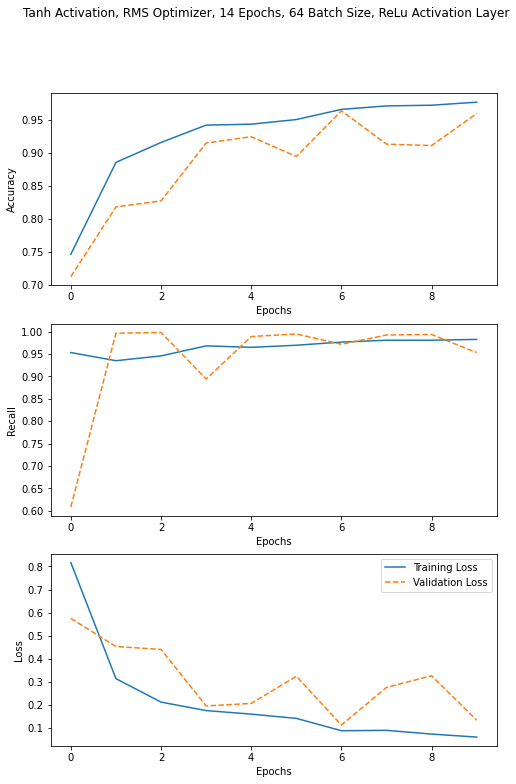

In [121]:
fig, axs = plt.subplots(3, figsize = (8,12))

plt.suptitle("Tanh Activation, RMS Optimizer, 14 Epochs, 64 Batch Size, ReLu Activation Layer")

axs[0].plot(cnn4_epochs, cnn4_accuracy_train, label = 'Training Accuracy')
axs[0].plot(cnn4_epochs, cnn4_accuracy_val, linestyle = '--', label = 'Validation Accuracy')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
plt.legend()


axs[1].plot(cnn4_epochs, cnn4_recall_train, label = 'Training Recall')
axs[1].plot(cnn4_epochs, cnn4_recall_val, linestyle = '--', label = 'Validation Recall')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Recall")
plt.legend()


axs[2].plot(cnn4_epochs, cnn4_loss_train, label = 'Training Loss')
axs[2].plot(cnn4_epochs, cnn4_loss_val, linestyle = '--', label = 'Validation Loss')
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Loss")
plt.legend();

Thus far, CNN4 has been the most succesful when measuring both recall and accuracy. We will use it to predict on the test set.

In [59]:
cnn_test_results = cnn4.evaluate(test_images, test_labels)

20/20 [==============================] - 3s 156ms/step - loss: 1.0779 - accuracy: 0.7885 - recall_6: 0.9744


In [60]:
y_pred = np.round(cnn4.predict(test_images)).astype(int)
y_true = np.round(test_labels).astype(int)

In [61]:
confusion_matrix(y_true, y_pred)

array([[112, 122],
       [ 10, 380]], dtype=int64)

In [62]:
print(f'F1 score: {f1_score(y_true, y_pred)}')
print(f'Accuracy score: {accuracy_score(y_true, y_pred)}')
print(f'Recall score: {recall_score(y_true, y_pred)}')

F1 score: 0.852017937219731
Accuracy score: 0.7884615384615384
Recall score: 0.9743589743589743


## Application of Transfer Learning

The test performed well in regard to recall, but did struggle with accuracy and a high rate of false positives. While in the scope of this problem this is not as much of an issue, a stronger model would help reduce the cost of misdiagnosis to healthcare companies as well as the emotional toll of repeated hospital visits to patients.

We have chosen to first apply a transfer learning method by using a convolutional base trained on the ImageNet dataset of over 1.2 million images. Because the images we are classifying are binary, we will set `include_top` to `False` as the top few layers of this model will not be useful for the task.  
We selected using the EfficientNet model due to its relatively low weight and high performance.

In [63]:
from tensorflow.keras.applications import EfficientNetB0

The images had to be converted into an rgb-esque format with 3 channels for them to work with the convolutional base's architecture, so we generated a new dataset to fit the requirement.

In [103]:
transfer_train_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=2843,
                                                 color_mode = 'rgb', 
                                                 class_mode = 'categorical'                             
                                                 )

transfer_test_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=624,
                                            color_mode = 'rgb', 
                                            class_mode = 'categorical')


Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [104]:
transfer_train_images, transfer_train_labels = next(transfer_train_gen)
transfer_test_images, transfer_test_labels = next(transfer_test_gen)

In [105]:
transfer_train_images.shape, transfer_train_labels.shape

((2843, 224, 224, 3), (2843, 2))

In [106]:
train_y = np.reshape(transfer_train_labels[:], (5686,1))

In [107]:
train_y.shape

(5686, 1)

In [108]:
conv_base = EfficientNetB0(include_top = False, 
                           weights = 'imagenet',
                           classes = 2)

In [109]:
transfer_model = models.Sequential()
transfer_model.add(conv_base)
transfer_model.add(layers.GlobalMaxPooling2D())

transfer_model.add(Dropout(.3))
transfer_model.add(layers.Flatten())
transfer_model.add(layers.Dense(64, activation='relu'))
transfer_model.add(layers.Dense(1, activation='softmax'))##the layers on top are similar to the final scratch model's layers

In [110]:
conv_base.trainable = False

for layer in transfer_model.layers:
    print(layer.name, layer.trainable)

print(len(transfer_model.trainable_weights))

efficientnetb0 False
global_max_pooling2d_5 True
dropout_7 True
flatten_9 True
dense_25 True
dense_26 True
4


In [111]:
transfer_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))
##instantiating Early Stopping with a 3-epoch tolerance for minimizing the validation loss

In [102]:
np.random.seed(123)
conv_base_history = transfer_model.fit(x=transfer_train_images, y=train_y,  
                                       epochs = 20, 
                                       batch_size = 32, 
                                       validation_split=.25, 
                                       callbacks = [es])

Epoch 1/20


TypeError: 'NoneType' object is not callable

In [92]:
conv_base_history.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x1f08f7017f0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.8272767066955566,
   0.6617735624313354,
   0.5785691142082214,
   0.5739938616752625,
   0.5770297646522522],
  'accuracy': [0.6572375297546387,
   0.7097349762916565,
   0.7438837885856628,
   0.743628978729248,
   0.743628978729248],
  'recall_7': [0.8152844309806824, 0.9342014789581299, 1.0, 1.0, 1.0],
  'val_loss': [0.6259242296218872,
   0.5753017663955688,
   0.5760843753814697,
   0.5756241679191589,
   0.5759062767028809],
  'val_accuracy': [0.7377675771713257,
   0.7377675771713257,
   0.7377675771713257,
   0.7377675771713257,
   0.7377675771713257],
  'val_recall_7': [1.0, 1.0, 1.0, 1.0, 1.0]},
 'params': {'verbose': 1, 'epochs': 20, 'steps': 123},
 'epoch': [0, 1, 2, 3, 4]}

In [93]:
conv_epochs = conv_base_history.epoch

conv_loss = conv_base_history.history['loss']
conv_accuracy = conv_base_history.history['accuracy']
conv_recall = conv_base_history.history['recall_7']

conv_val_loss = conv_base_history.history['val_loss']
conv_val_accuracy = conv_base_history.history['val_accuracy']
conv_val_recall = conv_base_history.history['val_recall_7']

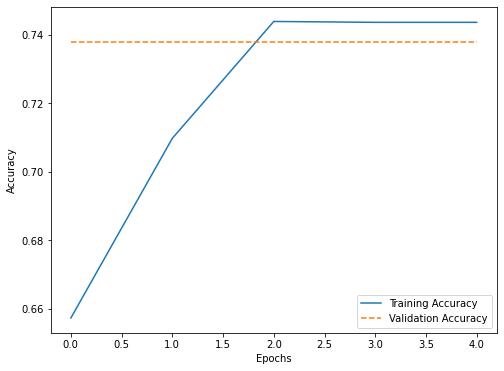

In [94]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(conv_epochs, conv_accuracy, label = 'Training Accuracy')
ax.plot(conv_epochs, conv_val_accuracy, linestyle = '--', label = 'Validation Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.legend();

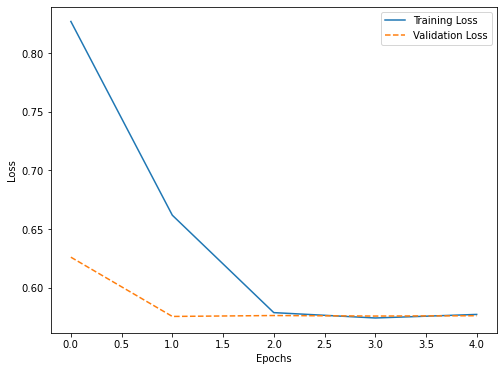

In [95]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(conv_epochs, conv_loss, label = 'Training Loss')
ax.plot(conv_epochs, conv_val_loss, linestyle = '--', label = 'Validation Loss')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.legend();

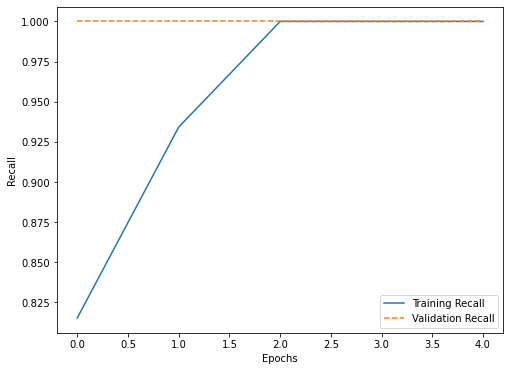

In [96]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(conv_epochs, conv_recall, label = 'Training Recall')
ax.plot(conv_epochs, conv_val_recall, linestyle = '--', label = 'Validation Recall')
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
plt.legend();

In [97]:
base_train_results = transfer_model.evaluate(rgb_train_images, train_y_rgb)

164/164 [==============================] - 185s 1s/step - loss: 0.5710 - accuracy: 0.7422 - recall_7: 1.0000


In [98]:
np.random.seed(111)
y_test_preds = transfer_model.predict(rgb_test_images)
y_test_pred_rgb = np.round(y_test_preds).astype(int)

In [99]:
y_test_true_rgb = test_y_rgb.astype(int)
confusion_matrix(y_test_true_rgb, y_test_pred_rgb)

array([[  0, 234],
       [  0, 390]], dtype=int64)

This model only predicted the positive class, with no false negatives. As far as usefulness goes, this model does not fit the bill. The next step here may be using data augmentation. 

## Transfer Learning Attempt 2

In [112]:
cnn2_base = EfficientNetB0(include_top = False, 
                           weights = 'imagenet',
                           classes = 2, 
                           classifier_activation = 'tanh',
                           drop_connect_rate = .4)

In [113]:
cnn2_model = models.Sequential()
cnn2_model.add(cnn2_base)

cnn2_model.add(layers.GlobalMaxPooling2D())


cnn2_model.add(layers.Dropout(.4, name="dropout_out"))
cnn2_model.add(layers.Dense(256, activation="relu"))
cnn2_model.add(layers.Dense(128, activation="relu"))
cnn2_model.add(layers.Dense(64, activation="relu"))
cnn2_model.add(layers.Dense(2, activation="sigmoid", name="fc_out"))

In [114]:
cnn2_base.trainable = False

for layer in cnn2_model.layers:
    print(layer.name, layer.trainable)

print(len(cnn2_model.trainable_weights))

efficientnetb0 False
global_max_pooling2d_6 True
dropout_out True
dense_27 True
dense_28 True
dense_29 True
fc_out True
8


In [115]:
cnn2_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_max_pooling2d_6 (Glob (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               327936    
_________________________________________________________________
dense_28 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
fc_out (Dense)               (None, 2)               

In [116]:
cnn2_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=(['accuracy'], metrics.Recall()))

In [117]:
history = cnn2_model.fit(x = transfer_train_images, y = transfer_train_labels,  
    epochs = 20,
    batch_size = 16, 
    validation_split = .25,
    verbose = 2, 
    callbacks = [es])

Epoch 1/20
134/134 - 89s - loss: 0.6774 - accuracy: 0.7101 - recall_13: 0.7050 - val_loss: 0.6517 - val_accuracy: 0.7173 - val_recall_13: 0.7173
Epoch 2/20
134/134 - 86s - loss: 0.6061 - accuracy: 0.7416 - recall_13: 0.7387 - val_loss: 0.6082 - val_accuracy: 0.7173 - val_recall_13: 0.7173
Epoch 3/20
134/134 - 86s - loss: 0.5885 - accuracy: 0.7383 - recall_13: 0.7378 - val_loss: 0.5971 - val_accuracy: 0.7173 - val_recall_13: 0.7173
Epoch 4/20
134/134 - 88s - loss: 0.5896 - accuracy: 0.7416 - recall_13: 0.7462 - val_loss: 0.6040 - val_accuracy: 0.7173 - val_recall_13: 0.7173
Epoch 5/20
134/134 - 89s - loss: 0.5805 - accuracy: 0.7467 - recall_13: 0.7458 - val_loss: 0.6022 - val_accuracy: 0.7173 - val_recall_13: 0.7173
Epoch 6/20
134/134 - 92s - loss: 0.5756 - accuracy: 0.7416 - recall_13: 0.7420 - val_loss: 0.5976 - val_accuracy: 0.7173 - val_recall_13: 0.7173
Epoch 00006: early stopping


In [119]:
train_results = cnn2_model.evaluate(transfer_train_images, transfer_train_labels)

89/89 [==============================] - 84s 939ms/step - loss: 0.5742 - accuracy: 0.7394 - recall_13: 0.7394


In [120]:
y_preds = np.round(cnn2_model.predict(transfer_train_images)).astype(int)
y_true = transfer_train_labels.astype(int)

In [125]:
y_true = y_true[:,1]

In [126]:
y_preds = y_preds[:,1]

In [127]:
confusion_matrix(y_true, y_preds)

array([[   0,  741],
       [   0, 2102]], dtype=int64)

This model also only predicted postive classes. The final scratch-build model performed better than layering onto a pre-trained model.

## Using LIME to interpret meaningful parts of images

In [ ]:
#pip install lime

In [117]:
import os
import keras
from tensorflow.keras.applications import inception_v3 as inc_net
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from lime import lime_image
import time
from skimage.segmentation import mark_boundaries
from skimage.io import imread

In [118]:
path_list = []
for pic in test_dir_pneumonia:
    #print(pic)
    path_list.append('../data/chest_xray/test/PNEUMONIA/' + pic)
#creates a list of the file path foreach image in pneumonia

In [135]:
def transform_img_fn(path_list):
    """Takes in a list of file paths from images, loads the images, 
    transforms the images adn outputs arrays fro these images"""
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(224, 224, 3), color_mode = 'rgb')
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = np.divide(x, 255.0).astype('double')
        out.append(x)
    return np.vstack(out)

In [136]:
X = transform_img_fn(path_list)
#transforms all images and puts in list

#yhat_test = model5.predict(X)

In [110]:
yhat_min = yhat_test == min(yhat_test)

yhat_max = yhat_test == max(yhat_test)

np.where (yhat_test ==  min(yhat_test)), np.where(yhat_test == max(yhat_test))
#how to find hte minimum

((array([281], dtype=int64), array([0], dtype=int64)),
 (array([85], dtype=int64), array([0], dtype=int64)))

In [111]:
min_explainer = lime_image.LimeImageExplainer()

max_explainer = lime_image.LimeImageExplainer()
#instantiate explainer obj

In [ ]:
#min_explanation = min_explainer.explain_instance(###, model5.predict, top_labels=5, hide_color=0, num_samples=1000)

#max_explanation = max_explainer.explain_instance(test_images[85], model5.predict, top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
min_temp, min_mask = min_explanation.get_image_and_mask(min_explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(min_temp / 2 + 0.5, min_mask))


max_temp, max_mask = max_explanation.get_image_and_mask(max_explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(max_temp / 2 + 0.5, max_mask))